# Multiclass Classification Model With PyTorch

In [1]:
# We'll start by importing all dependencies

import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
x, y = make_blobs(n_samples=1000,
    n_features=2,
    centers = 4,
    cluster_std = 1.5,
    random_state = 42,
    shuffle=True
)

In [3]:
x[:10]

array([[-8.41339595,  6.93516545],
       [-5.76648413, -6.43117072],
       [-6.04213682, -6.76610151],
       [ 3.95083749,  0.69840313],
       [ 4.25049181, -0.28154475],
       [-6.7941075 , -6.47722117],
       [ 5.21017561,  2.8890483 ],
       [-5.50513568, -6.36037688],
       [-6.54375599, -4.83389895],
       [ 6.44964229,  0.74776618]])

Let's split our data

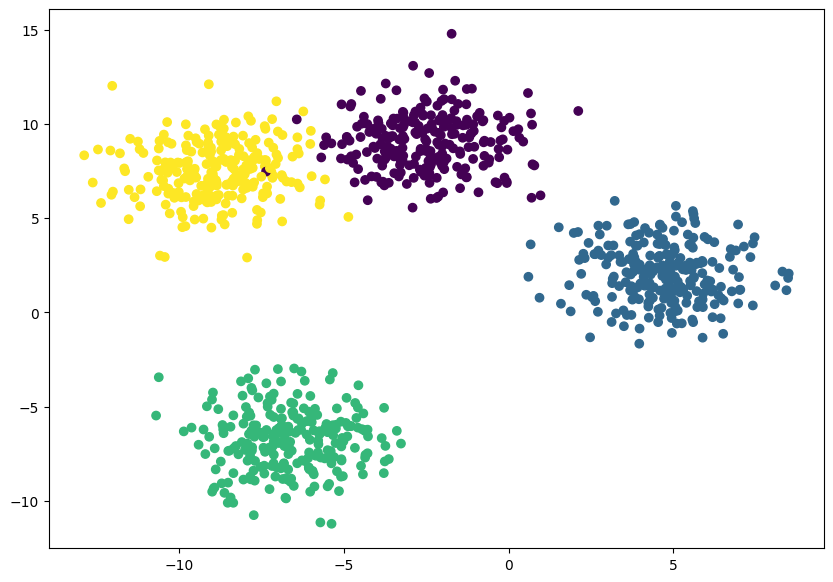

In [4]:
plt.figure(figsize=(10,7))
plt.scatter(x=x[:,0], y=x[:,1], c=y)
plt.show()

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2, shuffle=True)
len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [30]:
X_train, Y_train = torch.from_numpy(x_train).type(torch.float), torch.from_numpy(y_train).type(torch.LongTensor) # True labels need to be int for CrossEntropyLoss()
X_test, Y_test = torch.from_numpy(x_test).type(torch.float), torch.from_numpy(y_test).type(torch.LongTensor)

Great, we've got our data. Let's build our model

In [60]:
class MultiClassModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=2, out_features=15)
    self.linear_layer_2 = nn.Linear(in_features=15, out_features=15)
    self.linear_layer_3 = nn.Linear(in_features=15, out_features=4)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer_3(self.linear_layer_2(self.linear_layer(x)))

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [62]:
torch.manual_seed(42)

In [63]:
model_2 = MultiClassModel()
model_2

MultiClassModel(
  (linear_layer): Linear(in_features=2, out_features=15, bias=True)
  (linear_layer_2): Linear(in_features=15, out_features=15, bias=True)
  (linear_layer_3): Linear(in_features=15, out_features=4, bias=True)
)

In [64]:
model_2.parameters()

<generator object Module.parameters at 0x78a28dae26c0>

In [65]:
model_2.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984]])),
             ('linear_layer.bias',
              tensor([ 0.6386, -0.6007,  0.5459,  0.1177, -0.2296,  0.4370,  0.1102,  0.5713,
                       0.0773, -0.2230,  0.1900, -0.1918,  0.2976,  0.6313,  0.4087])),
             ('linear_layer_2.weight',
              tensor([[-0.1129,  0.1490,  0.0462,  0.1311, -0.1574, -0.255

In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr =0.1)

In [67]:
try:
  import torchmetrics
except:
  !pip install torchmetrics

In [68]:
from torchmetrics import Accuracy
accuracy = Accuracy(num_classes=4, task="Multiclass")

In [69]:
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 500
epoch_count = []
train_loss = []
loss_test = []
accuracy_train = []
accuracy_test = []

for epoch in tqdm(range(epochs)):
  model_2.train()

  logits = model_2(X_train)
  train_preds = torch.softmax(logits, dim=1).argmax(dim=1)
  # Calculate loss
  loss = loss_fn(logits, Y_train)

  # Zero the gradients
  optimizer.zero_grad()

  # Perform backpropagation
  loss.backward()

  # Step the optimizer
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test)

    test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

    # Calculate the loss
    test_loss = loss_fn(test_logits, Y_test)

  if epoch % 50 ==0:
    epoch_count.append(epoch)
    train_loss.append(loss.detach().numpy())
    loss_test.append(test_loss.detach().numpy())
    acc_train = accuracy(Y_train, train_preds)
    accuracy_train.append(acc_train)
    acc_test = accuracy(Y_test, test_preds)
    accuracy_test.append(acc_test)

    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Accuracy: {acc_train * 100:.2f}% | Test Loss: {test_loss} | Test accuracy: {acc_test* 100:.2f}%")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.035569667816162 | Test Accuracy: 50.38% | Test Loss: 0.5396914482116699 | Test accuracy: 75.50%
Epoch: 50 | Train Loss: 0.040366992354393005 | Test Accuracy: 99.12% | Test Loss: 0.03229358047246933 | Test accuracy: 99.50%
Epoch: 100 | Train Loss: 0.031635407358407974 | Test Accuracy: 99.12% | Test Loss: 0.02267983928322792 | Test accuracy: 99.50%
Epoch: 150 | Train Loss: 0.02886498160660267 | Test Accuracy: 99.12% | Test Loss: 0.019337890669703484 | Test accuracy: 99.50%
Epoch: 200 | Train Loss: 0.027541732415556908 | Test Accuracy: 99.12% | Test Loss: 0.017621422186493874 | Test accuracy: 99.50%
Epoch: 250 | Train Loss: 0.02676287107169628 | Test Accuracy: 99.12% | Test Loss: 0.016560696065425873 | Test accuracy: 99.50%
Epoch: 300 | Train Loss: 0.026237642392516136 | Test Accuracy: 99.12% | Test Loss: 0.0158282071352005 | Test accuracy: 99.50%
Epoch: 350 | Train Loss: 0.025847619399428368 | Test Accuracy: 99.12% | Test Loss: 0.01528279110789299 | Test accuracy

Amazing! Let's plot the loss curves and also the decision boundary

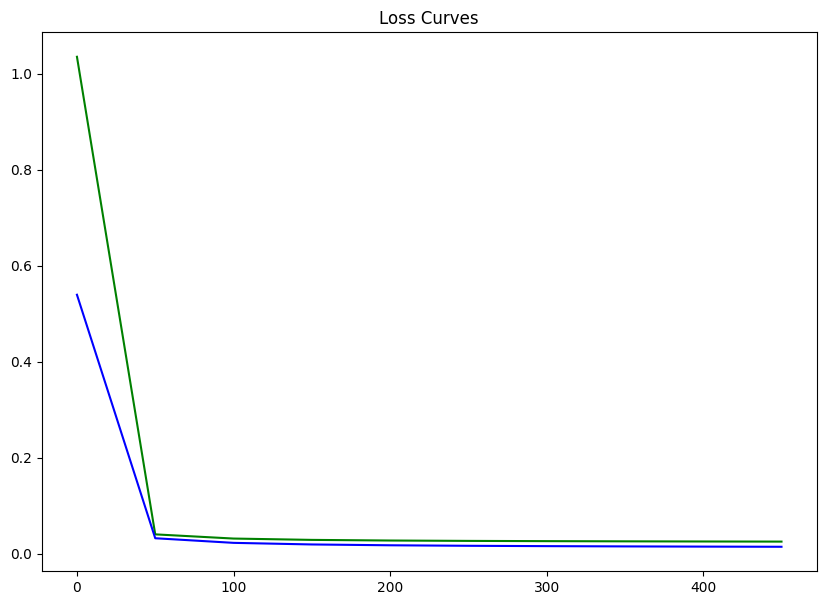

In [72]:
plt.figure(figsize=(10,7))
plt.plot(epoch_count,train_loss, c="g", label="Train Loss")
plt.plot(epoch_count, loss_test, c = "b", label="Test Loss")
plt.title("Loss Curves")
plt.show()

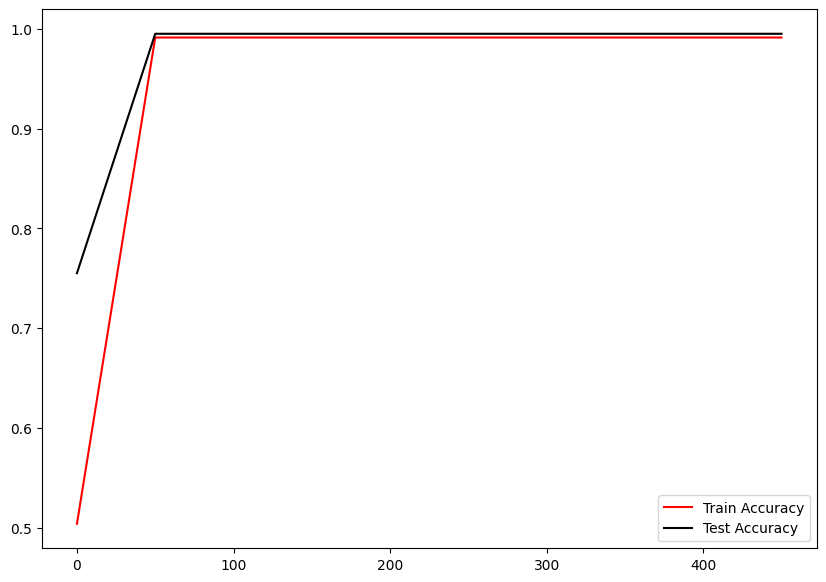

In [73]:
plt.figure(figsize=(10,7))
plt.plot(epoch_count, accuracy_train, c="r", label="Train Accuracy")
plt.plot(epoch_count, accuracy_test, c="black", label="Test Accuracy")
plt.legend()
plt.show()

In [74]:
#Let's plot thhe decision boundary

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File already exists")
else:
  print("Downloading file")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



In [75]:
from helper_functions import plot_predictions, plot_decision_boundary

Text(0.5, 1.0, 'Test Data')

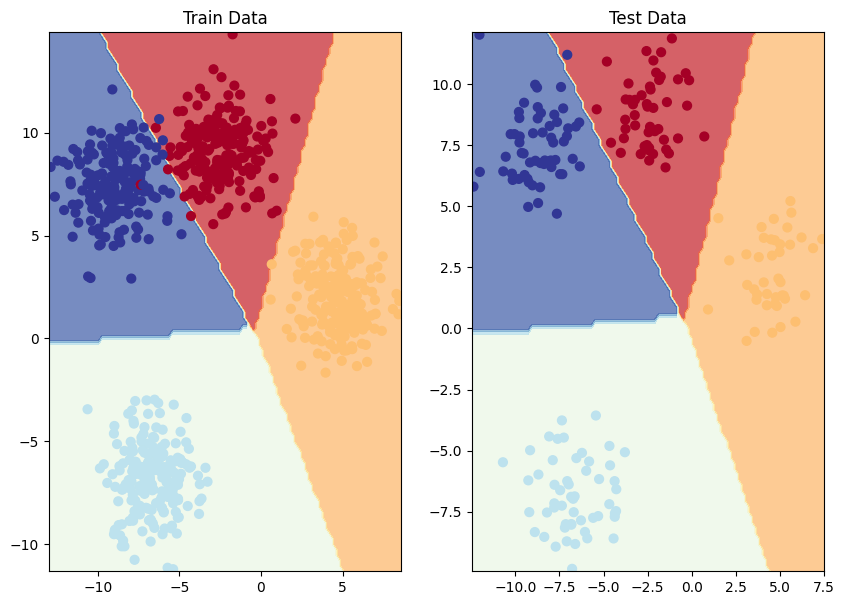

In [76]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plot_decision_boundary(model_2, X_train, Y_train)
plt.title("Train Data")
plt.subplot(1,2,2)
plot_decision_boundary(model_2, X_test, Y_test)
plt.title("Test Data")

Amazing! Now, let's save our model parameters and yet, still load our model again

In [80]:
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)
model_name = "multiclass.pth"
model_save_path = model_path / model_name

torch.save(obj=model_2.state_dict(),
           f=model_save_path)

In [83]:
# To load our model

# torch.nn.Module.load_state_dict(torch.load())
torch.manual_seed(42)
model_3 = MultiClassModel()

In [84]:
model_3.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [86]:
model_2.eval()
with torch.inference_mode():
  a = model_2(X_train)


In [87]:
model_3.eval()
with torch.inference_mode():
  b = model_3(X_train)

In [93]:
a==b

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        ...,
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])